In [1]:
#!pip install timm

In [2]:
import pandas as pd
import timm
import numpy as np
import json
import gc
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import albumentations
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2
import torchvision
from typing import Any, Dict, List, Union, Optional
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
import cv2
import torch
#from efficientnet_pytorch import EfficientNet
import numpy as np

from PIL import Image
from PIL import ImageFile

In [3]:
import pytorch_lightning
pytorch_lightning.seed_everything(42)

42

In [4]:
base_dir = r'C:\Users\Kaggle\Leaf_Classification\input'

In [5]:
### read csv and label mapping

labels = pd.read_csv(os.path.join(base_dir,'train.csv'))

with open(f'{base_dir}/label_num_to_disease_map.json') as f:
    label_mapper = json.load(f)

### Dataset class

In [6]:
class ImageClassificationDataset(Dataset):
    def __init__(
        self,
        image_names: List,
        transforms: Compose,
        labels: Optional[List[int]],
        img_path: str = '',
        mode: str = 'train',
        labels_to_ohe: bool = False,
        n_classes: int = 5,
    ):
        """
        Image classification dataset.

        Args:
            df: dataframe with image id and bboxes
            mode: train/val/test
            img_path: path to images
            transforms: albumentations
        """

        self.mode = mode
        self.transforms = transforms
        self.img_path = img_path
        self.image_names = image_names
        if labels is not None:
            if not labels_to_ohe:
                self.labels = np.array(labels)
            else:
                self.labels = np.zeros((len(labels), n_classes))
                self.labels[np.arange(len(labels)), np.array(labels)] = 1

    def __getitem__(self, idx: int) -> Dict[str, np.array]:
        image_path = self.img_path + self.image_names[idx]
        image = cv2.imread(f'{image_path}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            raise FileNotFoundError(image_path)
        target = self.labels[idx]

        img = self.transforms(image=image)['image']
        sample = {'image_path': image_path, 'image': img, 'target': np.array(target).astype('int64')}

        return sample

    def __len__(self) -> int:
        return len(self.image_names)

### Augs

In [7]:
sz = 576
sz_efffnetb4 = 600
deit_size = 384

In [8]:
# TTA0_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)


# TTA1_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.HorizontalFlip(p=1),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)


# TTA2_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.VerticalFlip(p=1),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)


# TTA2_5_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.Transpose(p=1.),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)

# TTA3_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.HueSaturationValue(
#                 hue_shift_limit=0.2, 
#                 sat_shift_limit=0.2, 
#                 val_shift_limit=0.2, 
#                 p=1
#             ),
#            albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)


# TTA4_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.RandomBrightnessContrast(
#                 brightness_limit=(-0.1,0.1), 
#                 contrast_limit=(-0.1, 0.1), 
#                 p=1.
#             ),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)


# TTA5_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             albumentations.Cutout(p=1.), 
#             ToTensorV2()],
#             p=1.)

# TTA6_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.ShiftScaleRotate(p=1.),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             ToTensorV2()],
#             p=1.)

# TTA7_deit = albumentations.Compose([
#             albumentations.CenterCrop(600, 600,p=1),
#             albumentations.Resize(deit_size,deit_size,cv2.INTER_AREA),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             albumentations.CoarseDropout(p=1.),
#             ToTensorV2()],
#             p=1.)

In [9]:
TTA0_deit = albumentations.Compose([
            albumentations.Resize(deit_size, deit_size,p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA1_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.HorizontalFlip(p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA2_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.VerticalFlip(p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA2_5_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.Transpose(p=1.),
           albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)

TTA3_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=1
            ),
           albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA4_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=1.
            ),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA5_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            albumentations.Cutout(p=1.), 
            ToTensorV2()],
            p=1.)

TTA6_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.ShiftScaleRotate(p=1.),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)

TTA7_deit = albumentations.Compose([
            albumentations.RandomResizedCrop(deit_size, deit_size),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            albumentations.CoarseDropout(p=1.),
            ToTensorV2()],
            p=1.)

In [10]:
TTA0 = albumentations.Compose([
            albumentations.Resize(sz, sz,p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA1 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.HorizontalFlip(p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA2 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.VerticalFlip(p=1),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA2_5 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.Transpose(p=1.),
           albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)

TTA3 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=1
            ),
           albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA4 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=1.
            ),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)


TTA5 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            albumentations.Cutout(p=1.), 
            ToTensorV2()],
            p=1.)

TTA6 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.ShiftScaleRotate(p=1.),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            ToTensorV2()],
            p=1.)

TTA7 = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            albumentations.CoarseDropout(p=1.),
            ToTensorV2()],
            p=1.)

In [11]:
infer_augs_effnet = albumentations.Compose([
            albumentations.RandomResizedCrop(sz_efffnetb4, sz_efffnetb4),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5), 
            ToTensorV2()],
            p=1.)


infer_augs_resnext = albumentations.Compose([
            albumentations.RandomResizedCrop(sz, sz),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5), 
            ToTensorV2()],
            p=1.)

### PL module

In [12]:
def freeze_until(net: Any, param_name: str = None) -> None:
    """
    Freeze net until param_name


    Args:
        net:
        param_name:

    """
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

class BasicEncoder(nn.Module):
    def __init__(
        self,
        arch: str = 'resnet18',
        source: str = 'torchvision',
        pretrained: str = None,
        n_layers: int = -1,
        freeze: bool = False,
        to_one_channel: bool = False,
        freeze_until_layer: str = None,
    ) -> None:
        """
        Initialize Encoder.

        Args:
            num_classes: the number of target classes, the size of the last layer's output
            arch: the name of the architecture form pretrainedmodels
            pretrained: the mode for pretrained model from pretrainedmodels
            n_layers: number of layers to keep
            freeze: to freeze model
            freeze_until: freeze until this layer. If None, then freeze all layers
        """
        super().__init__()
        if source == 'timm':
            net = timm.create_model(arch, pretrained=pretrained)
            self.output_dimension = list(net.children())[-1].in_features
        else:
            print("Not implemented")
            
        if freeze:
            freeze_until(net, freeze_until_layer)
        
        layers = list(net.children())[:n_layers]    
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        output = self.layers(x)

        return output

In [13]:
class BasicDecoder(nn.Module):
    def __init__(self, pool_output_size: int = 1, n_classes: int = 5, output_dimension: int = 512) -> None:
        """
        Initialize Decoder.

        Args:
            pool_output_size: the size of the result feature map after adaptive pooling layer
            n_classes: n classes to output
            output_dimension: output dimension of encoder
        """
        super().__init__()
        #self.pool = nn.AdaptiveAvgPool2d(output_size=pool_output_size)
        self.fc = nn.Linear(output_dimension , n_classes)

    def forward(self, x):
        #x = self.pool(x)
        output = self.fc(x.view(x.size()[0], -1))
        return output

In [14]:
class BasicDecoder_newhead(nn.Module):
    def __init__(self, pool_output_size: int = 1, n_classes: int = 5, output_dimension: int = 512) -> None:
        """
        Initialize Decoder.

        Args:
            pool_output_size: the size of the result feature map after adaptive pooling layer
            n_classes: n classes to output
            output_dimension: output dimension of encoder
        """
        super().__init__()
        #self.pool = nn.AdaptiveAvgPool2d(output_size=pool_output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_dimension, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        #x = self.pool(x)
        output = self.fc(x.view(x.size()[0], -1))
        return output


In [15]:
class Net_B4_newhead(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='tf_efficientnet_b4_ns',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder_newhead(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [16]:
class Net_B3(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='tf_efficientnet_b3_ns',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder_newhead(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [17]:
class Net_B4(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='tf_efficientnet_b4_ns',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [18]:
class Net_B5(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='tf_efficientnet_b5_ns',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [19]:
class BasicDecoder_seresnext(nn.Module):
    def __init__(self, pool_output_size: int = 1, n_classes: int = 5, output_dimension: int = 512) -> None:
        """
        Initialize Decoder.

        Args:
            pool_output_size: the size of the result feature map after adaptive pooling layer
            n_classes: n classes to output
            output_dimension: output dimension of encoder
        """
        super().__init__()
        #self.pool = nn.AdaptiveAvgPool2d(output_size=pool_output_size)
        #self.fc = nn.Linear(output_dimension , n_classes)
        self.fc = nn.Sequential(
            nn.Linear(output_dimension, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 5),
        )
    def forward(self, x):
        #x = self.pool(x)
        output = self.fc(x.view(x.size()[0], -1))
        return output

In [20]:
class seResnextNet(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='seresnext50_32x4d',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder_seresnext(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [21]:
class ResnextNet(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='resnext50_32x4d',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [22]:
class ResnextNet50d(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='resnext50d_32x4d',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder_newhead(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [23]:
class resnest50d(nn.Module):
    def __init__(self) -> None:
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = BasicEncoder(arch='resnest50d_1s4x24d',
                                    source='timm',
                                    pretrained=False,
                                    n_layers=-1,
                                    freeze=False,
                                    to_one_channel=False,
                                    freeze_until_layer=None)
        self.decoder = BasicDecoder_newhead(1,5,self.encoder.output_dimension)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, targets):
        out = self.encoder(x)
        logits = self.decoder(out)
        loss = self.loss(logits, targets).view(1)
        return logits, loss

In [24]:
class DEIT(nn.Module):
    def __init__(self) -> None:
        
        """
        Model class.

        Args:
            cfg: main config
        """
        super().__init__()
        self.encoder = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)
        output_dimension = list(self.encoder.children())[-1].in_features

        self.encoder.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 5),
        )
        self.loss = nn.CrossEntropyLoss()
    def forward(self, x, targets):
        logits = self.encoder(x)
        loss = self.loss(logits, targets).view(1)
        return logits, loss


In [25]:
class LitCassava(pl.LightningModule):
    def __init__(self, model):
        super(LitCassava, self).__init__()
        self.model = model
        self.metric = pl.metrics.Accuracy()
        self.learning_rate = 1e-4

    def forward(self, x, targets, *args, **kwargs):
        return self.model(x, targets)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

        return (
            [optimizer],
            [{'scheduler': scheduler, 'interval': 'epoch', 'monitor': 'valid_loss'}],
        )

    def training_step(
        self, batch: torch.Tensor, batch_idx: int
    ) -> Union[int, Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]]:
        image = batch['image']
        target = batch['target']
        logits, loss = self(image, target)
        score = self.metric(logits.argmax(1), target)
        logs = {'train_loss': loss, f'train_accuracy': score}
        return {
            'loss': loss,
            'log': logs,
            'progress_bar': logs,
            'logits': logits,
            'target': target,
            f'train_accuracy': score,
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        y_true = torch.cat([x['target'] for x in outputs])
        y_pred = torch.cat([x['logits'] for x in outputs])
        score = self.metric(y_pred.argmax(1), y_true)
        
        logs = {'train_loss': avg_loss, 'train_accuracy': score}
        return {'log': logs, 'progress_bar': logs}

    def validation_step(
        self, batch: torch.Tensor, batch_idx: int
    ) -> Union[int, Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]]:
        image = batch['image']
        target = batch['target']
        logits, loss = self(image, target)
        score = self.metric(logits.argmax(1), target)
        logs = {'valid_loss': loss, f'valid_accuracy': score}

        return {
            'loss': loss,
            'log': logs,
            'progress_bar': logs,
            'logits': logits,
            'target': target,
            f'valid_accuracy': score,
        }

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        y_true = torch.cat([x['target'] for x in outputs])
        y_pred = torch.cat([x['logits'] for x in outputs])
        score = self.metric(y_pred.argmax(1), y_true)

        # score = torch.tensor(1.0, device=self.device)
        logs = {'valid_loss': avg_loss, f'valid_accuracy': score, 'accuracy': score}
        return {'valid_loss': avg_loss, 'log': logs, 'progress_bar': logs}

In [26]:
labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [27]:
# path = "../input/cassava-leaf-disease-classification/"
# sub = pd.read_csv(f'{path}/sample_submission.csv')
# sub.head()

In [28]:
def getloader(df,path,bs=8,fold=0,tta=0,deit=False):
    
    if not deit:
        if tta == 0:
            augs = TTA0
        if tta == 1:
            augs = TTA1
        if tta == 2:
            augs = TTA2
        if tta == 3:
            augs = TTA2_5
        if tta == 4:
            augs = TTA3
        if tta == 5:
            augs = TTA4
        if tta == 6:
            augs = TTA5
        if tta == 7:
            augs = TTA6
        if tta == 8:
            augs = TTA7
    else:
        if tta == 0:
            augs = TTA0_deit
        if tta == 1:
            augs = TTA1_deit
        if tta == 2:
            augs = TTA2_deit
        if tta == 3:
            augs = TTA2_5_deit
        if tta == 4:
            augs = TTA3_deit
        if tta == 5:
            augs = TTA4_deit
        if tta == 6:
            augs = TTA5_deit
        if tta == 7:
            augs = TTA6_deit
        if tta == 8:
            augs = TTA7_deit
    
    print(f"Using TTA: {tta} and DEIT:{deit}")
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    train_indexes, valid_indexes = list(folds.split(df, df['label']))[fold]

    train_df = df.iloc[train_indexes]
    valid_df = df.iloc[valid_indexes]


    train_dataset = ImageClassificationDataset(image_names=train_df['image_id'].values,
                                                    transforms=augs,
                                                    labels=train_df['label'].values,
                                                    img_path=path,
                                                    mode='train',
                                                    labels_to_ohe=False,
                                                    n_classes=5)
    valid_dataset = ImageClassificationDataset(image_names=valid_df['image_id'].values,
                                                    transforms=augs,
                                                    labels=valid_df['label'].values,
                                                    img_path=path,
                                                    mode='valid',
                                                    labels_to_ohe=False,
                                                    n_classes=5)
    
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=bs,num_workers=0,shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=bs,num_workers=0,shuffle=False)

    return train_loader,valid_loader,valid_indexes

In [29]:
# models = os.listdir('../input/leaves-tf-enet-b4-ns-576-finetune-temperedloss/')
# modelsPath = [os.path.join('../input/leaves-tf-enet-b4-ns-576-finetune-temperedloss',i) for i in models]
# modelsPath

In [30]:
from tqdm import tqdm
def getPreds(test_loader,lit_model,logitsOut=True):
    predictions = []
    
    for batch in tqdm(test_loader):
        image = batch['image'].to('cuda')
        target = batch['target'].to('cuda')
        with torch.no_grad():
            outputs = lit_model.model(image, target)[0]
            _outputs = outputs.softmax(1).detach().cpu().numpy()
            preds = outputs.argmax(1).detach().cpu().numpy()
            if not logitsOut:
                predictions.append(preds)
            else:
                #predictions[range(len(_outputs))] += _outputs
                predictions.append(_outputs)
    return np.array(predictions)

In [31]:
TTA = 2

### Preds for DEIT

In [32]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\DEIT_Mixup_without_hesitation_After_Epoch10\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\DEIT_Mixup_without_hesitation_After_Epoch10\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\DEIT_Mixup_without_hesitation_After_Epoch10\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\DEIT_Mixup_without_hesitation_After_Epoch10\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\DEIT_Mixup_without_hesitation_After_Epoch10\avgWeights\_Avg_fold_4.ckpt'}
             


In [33]:
preds_DEIT = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):    
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = DEIT()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)      
#    lit_model.load_state_dict(checkpoint['state_dict'])  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta,deit=True)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_DEIT[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


Using cache found in C:\Users\Rajneesh Tiwari/.cache\torch\hub\facebookresearch_deit_main
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:True


100%|██████████| 134/134 [01:10<00:00,  1.90it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.01it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Using cache found in C:\Users\Rajneesh Tiwari/.cache\torch\hub\facebookresearch_deit_main


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.02it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.02it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Using cache found in C:\Users\Rajneesh Tiwari/.cache\torch\hub\facebookresearch_deit_main


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.01it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.02it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Using cache found in C:\Users\Rajneesh Tiwari/.cache\torch\hub\facebookresearch_deit_main


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.01it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.01it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Using cache found in C:\Users\Rajneesh Tiwari/.cache\torch\hub\facebookresearch_deit_main


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.02it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:True


100%|██████████| 134/134 [01:06<00:00,  2.02it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [34]:
preds_mean_DEIT = preds_DEIT.copy()
preds_mean_DEIT[:,0]= preds_DEIT[:,0]/(1+np.sqrt(0.05))
preds_mean_DEIT[:,1]= preds_DEIT[:,1]/(1+np.sqrt(0.102))
preds_mean_DEIT[:,2]= preds_DEIT[:,2]/(1+np.sqrt(0.111))
preds_mean_DEIT[:,3]= preds_DEIT[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_DEIT[:,4]= preds_DEIT[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_DEIT,1)

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_DEIT,1))

(0.8920876758424078, 0.893396270505211)

In [36]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect()

218

### Preds for effnet B3

In [37]:
#modelsDir = os.listdir(r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\'')

modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b3_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b3_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b3_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b3_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b3_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_4.ckpt'}
             


In [38]:
# modelsDir = os.listdir(r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\)

# modelsPath = [os.path.join(r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\best_ones',i) for i in models]
# modelsPath

In [39]:
preds_effnet_b3 = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):    
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = Net_B3()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)      
#    lit_model.load_state_dict(checkpoint['state_dict'])  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_effnet_b3[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:16<00:00,  1.76it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:15<00:00,  1.77it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:15<00:00,  1.76it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:16<00:00,  1.75it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [40]:
preds_mean_effnetb3 = preds_effnet_b3.copy()
preds_mean_effnetb3[:,0]= preds_effnet_b3[:,0]/(1+np.sqrt(0.05))
preds_mean_effnetb3[:,1]= preds_effnet_b3[:,1]/(1+np.sqrt(0.102))
preds_mean_effnetb3[:,2]= preds_effnet_b3[:,2]/(1+np.sqrt(0.111))
preds_mean_effnetb3[:,3]= preds_effnet_b3[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_effnetb3[:,4]= preds_effnet_b3[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_effnetb3,1)

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_effnet_b3,1))

(0.8902649904192177, 0.8952656914520727)

In [42]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect()

276

### Preds for seresnext

In [43]:
#modelsDir = os.listdir(r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\'')

modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_4.ckpt'
             }


In [44]:
# modelsDir = os.listdir(r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\)

# modelsPath = [os.path.join(r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\seresnext50_32x4d_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\best_ones',i) for i in models]
# modelsPath

In [45]:
preds_seresnext = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA

for f in range(5):
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = seResnextNet()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=128,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_seresnext[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.96s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.96s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.95s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.96s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.95s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.96s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.95s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.96s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.95s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/34 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 34/34 [01:40<00:00,  2.96s/it]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [46]:
preds_mean_seresnext = preds_seresnext.copy()
preds_mean_seresnext[:,0]= preds_mean_seresnext[:,0]/(1+np.sqrt(0.05))
preds_mean_seresnext[:,1]= preds_mean_seresnext[:,1]/(1+np.sqrt(0.102))
preds_mean_seresnext[:,2]= preds_mean_seresnext[:,2]/(1+np.sqrt(0.111))
preds_mean_seresnext[:,3]= preds_mean_seresnext[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_seresnext[:,4]= preds_mean_seresnext[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_seresnext,1)

In [47]:
# classOut = np.argmax(preds_seresnext,1)
# classOut.shape

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_seresnext,1))

(0.894517923073328, 0.8954058980230873)

In [49]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect()

267

In [50]:
torch.cuda.empty_cache()

In [51]:
gc.collect()

40

### Preds for Effnet b4 Taylor Loss - 2 SWA

In [52]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\Top 2\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\Top 2\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\Top 2\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\Top 2\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\Top 2\avgWeights\_Avg_fold_4.ckpt'
             }

In [53]:
preds_effnet_b4_taylor = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):    
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = Net_B4_newhead()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)      
#    lit_model.load_state_dict(checkpoint['state_dict'])  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_effnet_b4_taylor[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.60it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [54]:
preds_mean_effnetb4_taylor = preds_effnet_b4_taylor.copy()
preds_mean_effnetb4_taylor[:,0]= preds_effnet_b4_taylor[:,0]/(1+np.sqrt(0.05))
preds_mean_effnetb4_taylor[:,1]= preds_effnet_b4_taylor[:,1]/(1+np.sqrt(0.102))
preds_mean_effnetb4_taylor[:,2]= preds_effnet_b4_taylor[:,2]/(1+np.sqrt(0.111))
preds_mean_effnetb4_taylor[:,3]= preds_effnet_b4_taylor[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_effnetb4_taylor[:,4]= preds_effnet_b4_taylor[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_effnetb4_taylor,1)

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_effnet_b4_taylor,1))

(0.8940505678366126, 0.8963873440201897)

In [56]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect();torch.cuda.empty_cache()

### Preds for Effnet b4 Taylor Loss - 3 SWA

In [57]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_ns_sz_576_Mixup_0.3_TaylorLoss_timm_newhead\avgWeights\_Avg_fold_4.ckpt'
             }


In [58]:
preds_effnet_b4_taylor_3SWA = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):    
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = Net_B4_newhead()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)      
#    lit_model.load_state_dict(checkpoint['state_dict'])  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_effnet_b4_taylor_3SWA[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:24<00:00,  1.58it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.60it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:24<00:00,  1.58it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:26<00:00,  1.54it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.60it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [59]:
preds_mean_effnetb4_taylor_3SWA = preds_effnet_b4_taylor_3SWA.copy()
preds_mean_effnetb4_taylor_3SWA[:,0]= preds_effnet_b4_taylor_3SWA[:,0]/(1+np.sqrt(0.05))
preds_mean_effnetb4_taylor_3SWA[:,1]= preds_effnet_b4_taylor_3SWA[:,1]/(1+np.sqrt(0.102))
preds_mean_effnetb4_taylor_3SWA[:,2]= preds_effnet_b4_taylor_3SWA[:,2]/(1+np.sqrt(0.111))
preds_mean_effnetb4_taylor_3SWA[:,3]= preds_effnet_b4_taylor_3SWA[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_effnetb4_taylor_3SWA[:,4]= preds_effnet_b4_taylor_3SWA[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_effnetb4_taylor_3SWA,1)

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_effnet_b4_taylor_3SWA,1))

(0.8947048651680142, 0.8955928401177735)

In [61]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect();torch.cuda.empty_cache()

### Preds for B4 focal cosine loss

In [62]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b4_sz_576_Mixup_0.3_focalCosinesLoss_timm_newhead\avgWeights\_Avg_fold_4.ckpt'
             }


In [63]:
preds_effnet_b4 = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):    
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = Net_B4_newhead()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)      
#    lit_model.load_state_dict(checkpoint['state_dict'])  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_effnet_b4[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.60it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [64]:
preds_mean_effnetb4 = preds_effnet_b4.copy()
preds_mean_effnetb4[:,0]= preds_effnet_b4[:,0]/(1+np.sqrt(0.05))
preds_mean_effnetb4[:,1]= preds_effnet_b4[:,1]/(1+np.sqrt(0.102))
preds_mean_effnetb4[:,2]= preds_effnet_b4[:,2]/(1+np.sqrt(0.111))
preds_mean_effnetb4[:,3]= preds_effnet_b4[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_effnetb4[:,4]= preds_effnet_b4[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_effnetb4,1)

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_effnet_b4,1))

(0.8961069308781605, 0.8982100294433799)

In [66]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect();torch.cuda.empty_cache()

### Ensemble b4 with deit

In [67]:
res_ = pd.DataFrame()
res_['b4_contrib'] = 0
#res['b5_contrib'] = 0
res_['deit_contrib'] = 0
res_ ['Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    b4_contrib = i
    deit_contrib = 1-i
    #print(i,j,1-i-j)
    ens_preds = (b4_contrib*preds_effnet_b4+deit_contrib*preds_DEIT)
    res_.loc[count,'b4_contrib'] = i
    res_.loc[count,'deit_contrib'] = 1-i
    res_.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
    count += 1

In [68]:
res_.sort_values(by=['Accuracy'],ascending=False)

,b4_contrib,deit_contrib,Accuracy
63,0.63,0.37,0.900547
55,0.55,0.45,0.900453
57,0.57,0.43,0.900453
59,0.59,0.41,0.900407
49,0.49,0.51,0.900360
...,...,...,...
4,0.04,0.96,0.894798
3,0.03,0.97,0.894658
2,0.02,0.98,0.894331
1,0.01,0.99,0.894097


### Ensemble 

In [69]:
res_ = pd.DataFrame()
res_['b4_contrib'] = 0
#res['b5_contrib'] = 0
res_['seresnext_contrib'] = 0
res_ ['Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    b4_contrib = i
    seresnext_contrib = 1-i
    #print(i,j,1-i-j)
    ens_preds = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext)
    res_.loc[count,'b4_contrib'] = i
    res_.loc[count,'seresnext_contrib'] = 1-i
    res_.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
    count += 1

In [70]:
res_.sort_values(by=['Accuracy'],ascending=False)

,b4_contrib,seresnext_contrib,Accuracy
21,0.21,0.79,0.901575
20,0.20,0.80,0.901482
18,0.18,0.82,0.901482
17,0.17,0.83,0.901435
22,0.22,0.78,0.901388
...,...,...,...
4,0.04,0.96,0.898490
3,0.03,0.97,0.897789
2,0.02,0.98,0.897556
1,0.01,0.99,0.896247


### Ensemble deit with b4 taylor loss

In [71]:
res_ = pd.DataFrame()
res_['b4_taylor_contrib'] = 0
#res['b5_contrib'] = 0
res_['deit_contrib'] = 0
res_ ['Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    b4_contrib = i
    deit_contrib = 1-i
    #print(i,j,1-i-j)
    ens_preds = (b4_contrib*preds_effnet_b4_taylor+deit_contrib*preds_DEIT)
    res_.loc[count,'b4_taylor_contrib'] = i
    res_.loc[count,'deit_contrib'] = 1-i
    res_.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
    count += 1

In [72]:
res_.sort_values(by=['Accuracy'],ascending=False)

,b4_taylor_contrib,deit_contrib,Accuracy
63,0.63,0.37,0.900033
64,0.64,0.36,0.899986
62,0.62,0.38,0.899893
49,0.49,0.51,0.899893
66,0.66,0.34,0.899893
...,...,...,...
4,0.04,0.96,0.895079
3,0.03,0.97,0.894845
2,0.02,0.98,0.894565
1,0.01,0.99,0.894191


### Ensemble seresnext with b4 taylor loss

In [73]:
res_ = pd.DataFrame()
res_['b4_taylor_contrib'] = 0
#res['b5_contrib'] = 0
res_['seresnext_contrib'] = 0
res_ ['Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    b4_contrib = i
    seresnext_contrib = 1-i
    #print(i,j,1-i-j)
    ens_preds = (b4_contrib*preds_effnet_b4_taylor+seresnext_contrib*preds_seresnext)
    res_.loc[count,'b4_taylor_contrib'] = i
    res_.loc[count,'seresnext_contrib'] = 1-i
    res_.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
    count += 1

In [74]:
res_.sort_values(by=['Accuracy'],ascending=False)

,b4_taylor_contrib,seresnext_contrib,Accuracy
10,0.10,0.90,0.900126
9,0.09,0.91,0.900033
11,0.11,0.89,0.900033
13,0.13,0.87,0.899986
17,0.17,0.83,0.899846
...,...,...,...
98,0.98,0.02,0.896995
99,0.99,0.01,0.896855
2,0.02,0.98,0.896714
1,0.01,0.99,0.896013


### Ensemble deit+seresnext+b4 focal cosine

In [75]:
res = pd.DataFrame()
res['b4_contrib'] = 0
res['deit_contrib'] = 0
res['seresnext_contrib'] = 0
res ['Accuracy'] = 0
res ['Adj_Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    for j in np.arange(0,1-i,0.01):
        b4_contrib = i
        deit_contrib = j
        seresnext_contrib = 1-i-j
        #print(i,j,1-i-j)
        ens_preds_adj = (b4_contrib*preds_mean_effnetb4+seresnext_contrib*preds_mean_seresnext+deit_contrib*preds_mean_DEIT)
        ens_preds = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+deit_contrib*preds_DEIT)
        res.loc[count,'b4_contrib'] = i
        res.loc[count,'seresnext_contrib'] = 1-i-j
        res.loc[count,'deit_contrib'] = j
        res.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
        res.loc[count,'Adj_Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds_adj,1))
        count += 1

In [76]:
res.sort_values(by=['Accuracy'],ascending=False)

,b4_contrib,deit_contrib,seresnext_contrib,Accuracy,Adj_Accuracy
2056,0.23,0.09,0.68,0.903024,0.900967
1978,0.22,0.09,0.69,0.902930,0.900967
1979,0.22,0.10,0.68,0.902930,0.901295
1738,0.19,0.09,0.72,0.902837,0.901154
1819,0.20,0.09,0.71,0.902837,0.901108
...,...,...,...,...,...
197,0.01,0.97,0.02,0.894331,0.892882
98,0.00,0.98,0.02,0.894284,0.892462
198,0.01,0.98,0.01,0.894191,0.892742
97,0.00,0.97,0.03,0.894191,0.892649


In [77]:
res.sort_values(by=['Adj_Accuracy'],ascending=False)

,b4_contrib,deit_contrib,seresnext_contrib,Accuracy,Adj_Accuracy
1232,0.13,0.10,0.77,0.901622,0.902229
1233,0.13,0.11,0.76,0.901528,0.902183
1321,0.14,0.12,0.74,0.901902,0.902136
1144,0.12,0.10,0.78,0.901855,0.902089
1405,0.15,0.10,0.75,0.901996,0.902042
...,...,...,...,...,...
198,0.01,0.98,0.01,0.894191,0.892742
97,0.00,0.97,0.03,0.894191,0.892649
96,0.00,0.96,0.04,0.894331,0.892649
98,0.00,0.98,0.02,0.894284,0.892462


### Preds for B5

In [78]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b5_ns_sz_576_timm_finetune_TemperedLoss_10Epochs\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b5_ns_sz_576_timm_finetune_TemperedLoss_10Epochs\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b5_ns_sz_576_timm_finetune_TemperedLoss_10Epochs\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b5_ns_sz_576_timm_finetune_TemperedLoss_10Epochs\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\tf_efficientnet_b5_ns_sz_576_timm_finetune_TemperedLoss_10Epochs\avgWeights\_Avg_fold_4.ckpt'
             }
             


In [79]:
preds_effnet_b5 = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = Net_B5()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_effnet_b5[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:36<00:00,  1.39it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.42it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.42it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.42it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.42it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [80]:
preds_mean_effnetb5 = preds_effnet_b5.copy()
preds_mean_effnetb5[:,0]= preds_effnet_b5[:,0]/(1+np.sqrt(0.05))
preds_mean_effnetb5[:,1]= preds_effnet_b5[:,1]/(1+np.sqrt(0.102))
preds_mean_effnetb5[:,2]= preds_effnet_b5[:,2]/(1+np.sqrt(0.111))
preds_mean_effnetb5[:,3]= preds_effnet_b5[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_effnetb5[:,4]= preds_effnet_b5[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_effnetb5,1)

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_effnet_b5,1))

(0.8945646585969996, 0.8968079637332337)

In [82]:
del _,softmaxOut,model,lit_model,checkpoint,test_loader; gc.collect();torch.cuda.empty_cache()

### Ensemble

In [83]:
res = pd.DataFrame()
res['b4_contrib'] = 0
res['b5_contrib'] = 0
res['seresnext_contrib'] = 0
res ['Accuracy'] = 0
res ['Adj_Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    for j in np.arange(0,1-i,0.01):
        b4_contrib = i
        b5_contrib = j
        seresnext_contrib = 1-i-j
        #print(i,j,1-i-j)
        ens_preds_adj = (b4_contrib*preds_mean_effnetb4+seresnext_contrib*preds_mean_seresnext+b5_contrib*preds_mean_effnetb5)
        ens_preds = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+b5_contrib*preds_effnet_b5)
        res.loc[count,'b4_contrib'] = i
        res.loc[count,'seresnext_contrib'] = 1-i-j
        res.loc[count,'b5_contrib'] = j
        res.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
        res.loc[count,'Adj_Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds_adj,1))
        count += 1

In [84]:
pd.set_option('display.max_rows',1000)

In [85]:
res.sort_values(by=['Accuracy'],ascending=False)

,b4_contrib,b5_contrib,seresnext_contrib,Accuracy,Adj_Accuracy
1146,0.12,0.12,0.76,0.903071,0.902276
1233,0.13,0.11,0.76,0.903024,0.902136
1234,0.13,0.12,0.75,0.902977,0.902276
1145,0.12,0.11,0.77,0.902930,0.902229
1055,0.11,0.10,0.79,0.902884,0.902183
...,...,...,...,...,...
99,0.00,0.99,0.01,0.896761,0.894705
2,0.00,0.02,0.98,0.896387,0.895499
100,0.01,0.00,0.99,0.896247,0.895546
1,0.00,0.01,0.99,0.895967,0.894798


In [86]:
res.sort_values(by=['Adj_Accuracy'],ascending=False)

,b4_contrib,b5_contrib,seresnext_contrib,Accuracy,Adj_Accuracy
416,0.04,0.22,0.74,0.901575,0.903024
1744,0.19,0.15,0.66,0.902229,0.903024
975,0.10,0.20,0.70,0.902556,0.903024
415,0.04,0.21,0.75,0.901668,0.903024
885,0.09,0.21,0.70,0.902556,0.903024
...,...,...,...,...,...
97,0.00,0.97,0.03,0.896855,0.895266
98,0.00,0.98,0.02,0.896901,0.895125
1,0.00,0.01,0.99,0.895967,0.894798
99,0.00,0.99,0.01,0.896761,0.894705


### resnest50d_1s4x24d

In [87]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnest50d_1s4x24d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnest50d_1s4x24d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnest50d_1s4x24d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnest50d_1s4x24d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnest50d_1s4x24d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_4.ckpt'
             }
             


In [88]:
preds_resnest50d = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = resnest50d()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
    lit_model.load_state_dict(checkpoint)  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_resnest50d[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.58it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.58it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [89]:
preds_mean_resnest50d = preds_resnest50d.copy()
preds_mean_resnest50d[:,0]= preds_resnest50d[:,0]/(1+np.sqrt(0.05))
preds_mean_resnest50d[:,1]= preds_resnest50d[:,1]/(1+np.sqrt(0.102))
preds_mean_resnest50d[:,2]= preds_resnest50d[:,2]/(1+np.sqrt(0.111))
preds_mean_resnest50d[:,3]= preds_resnest50d[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_resnest50d[:,4]= preds_resnest50d[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_resnest50d,1)

In [90]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_resnest50d,1))

(0.8924148245081086, 0.8951254848810581)

### Resnext50D

In [91]:
modelsPath = {0:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnext50_32x4d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_0.ckpt',
              1:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnext50_32x4d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_1.ckpt',
              2:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnext50_32x4d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_2.ckpt',
              3:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnext50_32x4d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_3.ckpt',
              4:r'C:\Users\Kaggle\Leaf_Classification\saved_models\Image 576\resnext50_32x4d_sz_576_Mixup_0.3_timm_newhead\avgWeights\_Avg_fold_4.ckpt'
             }
             


In [92]:
preds_resnext50d = np.zeros((len(labels),5))

train_img_path = 'C:/Users/Kaggle/Leaf_Classification/input/train_images/'
TTA = TTA
for f in range(5):
    softmaxOut = 0.
    print(f"Prediction for fold:{f}")
    modelPath = modelsPath[f]
    model = ResnextNet50d()
    lit_model = LitCassava(model)
    checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage)
#     lit_model.load_state_dict(checkpoint['state_dict'])  
    lit_model.load_state_dict(checkpoint)  
    lit_model.model.eval()
    lit_model.model.cuda()
    for tta in range(TTA):
        _,test_loader,valid_ix = getloader(labels,path=train_img_path,bs=32,fold=f,tta=tta)
        predictions = []
        softmaxOut+= (getPreds(test_loader,lit_model,logitsOut=True))
    preds_resnext50d[valid_ix,:] = np.vstack(softmaxOut)

Prediction for fold:0


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:1


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:2


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:3


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:34<00:00,  1.41it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:36<00:00,  1.39it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Prediction for fold:4


  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 0 and DEIT:False


100%|██████████| 134/134 [01:35<00:00,  1.40it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/134 [00:00<?, ?it/s]

Using TTA: 1 and DEIT:False


100%|██████████| 134/134 [01:36<00:00,  1.39it/s]
C:\Users\Anaconda_Stuff\envs\Pytorch_17_cuda11\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [93]:
preds_mean_resnext50d = preds_resnext50d.copy()
preds_mean_resnext50d[:,0]= preds_resnext50d[:,0]/(1+np.sqrt(0.05))
preds_mean_resnext50d[:,1]= preds_resnext50d[:,1]/(1+np.sqrt(0.102))
preds_mean_resnext50d[:,2]= preds_resnext50d[:,2]/(1+np.sqrt(0.111))
preds_mean_resnext50d[:,3]= preds_resnext50d[:,3]/(1+np.sqrt(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
preds_mean_resnext50d[:,4]= preds_resnext50d[:,4]/(1+np.sqrt(0.12))

classOut = np.argmax(preds_mean_resnext50d,1)

In [94]:
from sklearn.metrics import accuracy_score
accuracy_score(labels.label,classOut),accuracy_score(labels.label,np.argmax(preds_resnest50d,1))

(0.8906856101322616, 0.8951254848810581)

### Ensemble

In [95]:
res_all4 = pd.DataFrame()
res_all4['b4_contrib'] = 0
res_all4['b5_contrib'] = 0
res_all4['seresnext_contrib'] = 0
res_all4['resnest_contrib'] = 0

res_all4 ['Accuracy'] = 0
res_all4 ['Adj_Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.05):
    for j in np.arange(0,1-i,0.05):
        for k in np.arange(0,1-i-j,0.05):
            b4_contrib = i
            b5_contrib = j
            seresnext_contrib = k
            resnest_contrib = 1-i-j-k
            print(b4_contrib+b5_contrib+seresnext_contrib+resnest_contrib)
            #assert b4_contrib+b5_contrib+seresnext_contrib+resnest_contrib==1.
            #print(i,j,k,1-(i+j+k))
            ens_preds_adj = (b4_contrib*preds_mean_effnetb4+seresnext_contrib*preds_mean_seresnext+b5_contrib*preds_mean_effnetb5+resnest_contrib*preds_mean_resnest50d)
            ens_preds = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+b5_contrib*preds_effnet_b5+resnest_contrib*preds_resnest50d)
            res_all4.loc[count,'b4_contrib'] = i
            res_all4.loc[count,'seresnext_contrib'] = j
            res_all4.loc[count,'b5_contrib'] = k
            res_all4.loc[count,'resnest_contrib'] = 1-i-j-k
            res_all4.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
            res_all4.loc[count,'Adj_Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds_adj,1))
            count += 1

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0

In [96]:
res_all4.sort_values(by=['Accuracy'],ascending=False)

,b4_contrib,b5_contrib,seresnext_contrib,resnest_contrib,Accuracy,Adj_Accuracy
444,0.10,0.45,0.10,0.35,0.903444,0.902463
254,0.05,0.35,0.10,0.50,0.903444,0.902556
445,0.10,0.50,0.10,0.30,0.903351,0.902603
255,0.05,0.40,0.10,0.45,0.903351,0.902369
443,0.10,0.40,0.10,0.40,0.903257,0.902323
...,...,...,...,...,...,...
209,0.00,0.00,0.95,0.05,0.897088,0.895219
17,0.00,0.85,0.00,0.15,0.896761,0.895593
18,0.00,0.90,0.00,0.10,0.896294,0.895079
19,0.00,0.95,0.00,0.05,0.896013,0.894798


In [97]:
res_all4.sort_values(by=['Adj_Accuracy'],ascending=False)

,b4_contrib,b5_contrib,seresnext_contrib,resnest_contrib,Accuracy,Adj_Accuracy
458,0.10,0.35,0.15,0.40,0.902697,0.903164
289,0.05,0.45,0.20,0.30,0.901996,0.903117
303,0.05,0.40,0.25,0.30,0.901996,0.903117
286,0.05,0.30,0.20,0.45,0.901996,0.903024
292,0.05,0.60,0.20,0.15,0.902042,0.903024
...,...,...,...,...,...,...
209,0.00,0.00,0.95,0.05,0.897088,0.895219
18,0.00,0.90,0.00,0.10,0.896294,0.895079
1,0.00,0.05,0.00,0.95,0.897088,0.894985
19,0.00,0.95,0.00,0.05,0.896013,0.894798


In [98]:
#preds_DEIT
#preds_mean_DEIT

In [99]:
res_all4 = pd.DataFrame()
res_all4['DEIT_contrib'] = 0
res_all4['b5_contrib'] = 0
res_all4['seresnext_contrib'] = 0
res_all4['resnest_contrib'] = 0

res_all4 ['Accuracy'] = 0
res_all4 ['Adj_Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.05):
    for j in np.arange(0,1-i,0.05):
        for k in np.arange(0,1-i-j,0.05):
            DEIT_contrib = i
            b5_contrib = j 
            seresnext_contrib = k = 0 
            resnest_contrib = 1-i-j-k
            print(DEIT_contrib+b5_contrib+seresnext_contrib+resnest_contrib)
            #assert b4_contrib+b5_contrib+seresnext_contrib+resnest_contrib==1.
            #print(i,j,k,1-(i+j+k))
            ens_preds_adj = (DEIT_contrib*preds_mean_DEIT+seresnext_contrib*preds_mean_seresnext+b5_contrib*preds_mean_effnetb5+resnest_contrib*preds_mean_resnest50d)
            ens_preds = (DEIT_contrib*preds_DEIT+seresnext_contrib*preds_seresnext+b5_contrib*preds_effnet_b5+resnest_contrib*preds_resnest50d)
            res_all4.loc[count,'DEIT_contrib'] = i
            res_all4.loc[count,'seresnext_contrib'] = j
            res_all4.loc[count,'b5_contrib'] = k
            res_all4.loc[count,'resnest_contrib'] = 1-i-j-k
            res_all4.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
            res_all4.loc[count,'Adj_Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds_adj,1))
            count += 1

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.999999

In [100]:
np.corrcoef(np.max(preds_DEIT,1),np.max(preds_effnet_b4,1))

array([[1.        , 0.50621823],
       [0.50621823, 1.        ]])

In [101]:
np.corrcoef(np.max(preds_DEIT,1),np.max(preds_effnet_b5,1))

array([[1.       , 0.6057979],
       [0.6057979, 1.       ]])

In [102]:
np.corrcoef(np.max(preds_DEIT,1),np.max(preds_seresnext,1))

array([[1.        , 0.55770814],
       [0.55770814, 1.        ]])

In [103]:
np.corrcoef(np.max(preds_DEIT,1),np.max(preds_resnest50d,1))

array([[1.        , 0.48777121],
       [0.48777121, 1.        ]])

In [104]:
np.corrcoef(np.max(preds_seresnext,1),np.max(preds_resnest50d,1))

array([[1.        , 0.88647709],
       [0.88647709, 1.        ]])

In [105]:
np.corrcoef(np.max(preds_effnet_b4_taylor,1),np.max(preds_effnet_b4,1))

array([[1.        , 0.51496308],
       [0.51496308, 1.        ]])

In [106]:
res_all4.sort_values(by=['Accuracy'],ascending=False)

,DEIT_contrib,b5_contrib,seresnext_contrib,resnest_contrib,Accuracy,Adj_Accuracy
457,0.10,0.0,0.15,0.75,0.901809,0.900266
451,0.10,0.0,0.15,0.75,0.901809,0.900266
453,0.10,0.0,0.15,0.75,0.901809,0.900266
454,0.10,0.0,0.15,0.75,0.901809,0.900266
455,0.10,0.0,0.15,0.75,0.901809,0.900266
...,...,...,...,...,...,...
1541,0.85,0.0,0.00,0.15,0.894658,0.893163
1540,0.85,0.0,0.00,0.15,0.894658,0.893163
1545,0.90,0.0,0.00,0.10,0.894565,0.892602
1546,0.90,0.0,0.00,0.10,0.894565,0.892602


In [107]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels.label,np.argmax(preds_effnet_b4,1),normalize='true')

array([[0.66053358, 0.06623735, 0.03035879, 0.04691812, 0.19595216],
       [0.04020101, 0.81589767, 0.02558246, 0.04431247, 0.0740064 ],
       [0.00963956, 0.02137469, 0.80888516, 0.10435876, 0.05574183],
       [0.00136799, 0.00395197, 0.01086791, 0.97834017, 0.00547196],
       [0.07062476, 0.0508343 , 0.0523865 , 0.08420644, 0.741948  ]])

In [108]:
confusion_matrix(labels.label,np.argmax(preds_mean_effnetb4,1),normalize='true')

array([[0.67525299, 0.06531739, 0.03035879, 0.04139834, 0.18767249],
       [0.04385564, 0.82046597, 0.02558246, 0.03883052, 0.07126542],
       [0.01047779, 0.02221291, 0.82145851, 0.08968986, 0.05616094],
       [0.00182399, 0.00539596, 0.01329989, 0.97013224, 0.00934793],
       [0.07489329, 0.0523865 , 0.05316259, 0.07489329, 0.74466434]])

In [109]:
confusion_matrix(labels.label,np.argmax(preds_effnet_b4_taylor,1),normalize='true')

array([[0.65041398, 0.05703772, 0.02207912, 0.04139834, 0.22907084],
       [0.04111466, 0.80584742, 0.02832344, 0.04339881, 0.08131567],
       [0.01047779, 0.01927913, 0.81894384, 0.09974853, 0.05155071],
       [0.00189998, 0.00395197, 0.01322389, 0.97362821, 0.00729594],
       [0.06790842, 0.04889406, 0.04967016, 0.07916182, 0.75436554]])

In [110]:
confusion_matrix(labels.label,np.argmax(preds_mean_effnetb4_taylor,1),normalize='true')

array([[0.66881325, 0.05611776, 0.02115915, 0.03679853, 0.21711132],
       [0.04385564, 0.80813157, 0.02832344, 0.03974418, 0.07994518],
       [0.01215423, 0.01886002, 0.82523051, 0.09178541, 0.05196982],
       [0.00212798, 0.00509196, 0.01603587, 0.96572427, 0.01101991],
       [0.0717889 , 0.04967016, 0.0508343 , 0.06790842, 0.75979821]])

In [111]:
confusion_matrix(labels.label,np.argmax(preds_DEIT,1),normalize='true')

array([[0.64029439, 0.07543698, 0.0174793 , 0.04691812, 0.21987121],
       [0.04888077, 0.80721791, 0.02375514, 0.04431247, 0.07583371],
       [0.01383068, 0.0217938 , 0.77829003, 0.11986588, 0.06621961],
       [0.00151999, 0.00395197, 0.01071591, 0.97606019, 0.00775194],
       [0.06946061, 0.05277454, 0.04152115, 0.07838572, 0.75785797]])

In [112]:
confusion_matrix(labels.label,np.argmax(preds_effnet_b5,1),normalize='true')

array([[0.66513339, 0.05979761, 0.02391904, 0.0450782 , 0.20607176],
       [0.04202832, 0.81087254, 0.02878026, 0.03791686, 0.08040201],
       [0.01424979, 0.01927913, 0.81559095, 0.09513831, 0.05574183],
       [0.00227998, 0.00471196, 0.0129959 , 0.97256422, 0.00744794],
       [0.07023671, 0.0516104 , 0.0516104 , 0.07062476, 0.75591773]])

In [113]:
confusion_matrix(labels.label,np.argmax(preds_resnest50d,1),normalize='true')

array([[0.64949402, 0.06623735, 0.02851886, 0.04231831, 0.21343146],
       [0.04431247, 0.81269986, 0.02512563, 0.04385564, 0.0740064 ],
       [0.01215423, 0.02221291, 0.79798826, 0.11525566, 0.05238894],
       [0.00212798, 0.00357197, 0.01132391, 0.97689618, 0.00607995],
       [0.06790842, 0.05432674, 0.05471478, 0.08187815, 0.74117191]])

In [114]:
confusion_matrix(labels.label,np.argmax(preds_resnext50d,1),normalize='true')

array([[0.63845446, 0.05887764, 0.01931923, 0.05335787, 0.2299908 ],
       [0.04248515, 0.80813157, 0.02329831, 0.04842394, 0.07766103],
       [0.01173512, 0.01634535, 0.80134116, 0.1093881 , 0.06119028],
       [0.00212798, 0.00341997, 0.0126919 , 0.97431221, 0.00744794],
       [0.0717889 , 0.04656577, 0.04656577, 0.0814901 , 0.75358945]])

In [115]:
confusion_matrix(labels.label,np.argmax(preds_seresnext,1),normalize='true')

array([[0.65225391, 0.06623735, 0.01563937, 0.05151794, 0.21435143],
       [0.04659662, 0.80630425, 0.0246688 , 0.04659662, 0.07583371],
       [0.01257334, 0.02263202, 0.79086337, 0.11735122, 0.05658005],
       [0.00220398, 0.00349597, 0.00949992, 0.97963216, 0.00516796],
       [0.07566938, 0.05044626, 0.04811797, 0.08537059, 0.74039581]])

In [116]:
b4_contrib = 0.18
seresnext_contrib = 0.61
b5_contrib = 0.21
_ = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+b5_contrib*preds_effnet_b5)
print(accuracy_score(labels.label,np.argmax(_,1)))
confusion_matrix(labels.label,np.argmax(_,1),normalize='true')

0.9024629620974903


array([[0.67985281, 0.06347746, 0.02115915, 0.04783809, 0.18767249],
       [0.04294198, 0.82046597, 0.02421197, 0.04248515, 0.06989493],
       [0.01131601, 0.01927913, 0.81181894, 0.10645432, 0.0511316 ],
       [0.00151999, 0.00349597, 0.00980392, 0.98008816, 0.00509196],
       [0.06752037, 0.04928211, 0.04967016, 0.07993791, 0.75358945]])

In [117]:
deit_contrib = 0.15
seresnext_contrib = 0.25
resnest_contrib = 0.6
_ = (deit_contrib*preds_DEIT+seresnext_contrib*preds_seresnext+resnest_contrib*preds_resnest50d)
print(accuracy_score(labels.label,np.argmax(_,1)))
confusion_matrix(labels.label,np.argmax(_,1),normalize='true')

0.8993784175351685


array([[0.65685373, 0.07175713, 0.0174793 , 0.04599816, 0.20791168],
       [0.04705345, 0.81498401, 0.02192782, 0.04568296, 0.07035176],
       [0.01131601, 0.02263202, 0.79002515, 0.11567477, 0.06035205],
       [0.00151999, 0.00364797, 0.00889193, 0.98069615, 0.00524396],
       [0.06713232, 0.04928211, 0.04346139, 0.08071401, 0.75941017]])

In [118]:
res = pd.DataFrame()
res['b4_contrib'] = 0
res['deit_contrib'] = 0
res['seresnext_contrib'] = 0
res ['Accuracy'] = 0
res ['Adj_Accuracy'] = 0

count = 0
for i in np.arange(0,1,0.01):
    for j in np.arange(0,1-i,0.01):
        b4_contrib = i
        deit_contrib = j
        seresnext_contrib = 1-i-j
        #print(i,j,1-i-j)
        ens_preds_adj = (b4_contrib*preds_mean_effnetb4+seresnext_contrib*preds_mean_seresnext+deit_contrib*preds_mean_DEIT)
        ens_preds = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+deit_contrib*preds_DEIT)
        res.loc[count,'b4_contrib'] = i
        res.loc[count,'seresnext_contrib'] = 1-i-j
        res.loc[count,'deit_contrib'] = j
        res.loc[count,'Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds,1))
        res.loc[count,'Adj_Accuracy'] = accuracy_score(labels.label,np.argmax(ens_preds_adj,1))
        count += 1

In [119]:
res.sort_values(by=['Accuracy'],ascending=False)

,b4_contrib,deit_contrib,seresnext_contrib,Accuracy,Adj_Accuracy
2056,0.23,0.09,0.68,0.903024,0.900967
1978,0.22,0.09,0.69,0.902930,0.900967
1979,0.22,0.10,0.68,0.902930,0.901295
1738,0.19,0.09,0.72,0.902837,0.901154
1819,0.20,0.09,0.71,0.902837,0.901108
...,...,...,...,...,...
197,0.01,0.97,0.02,0.894331,0.892882
98,0.00,0.98,0.02,0.894284,0.892462
198,0.01,0.98,0.01,0.894191,0.892742
97,0.00,0.97,0.03,0.894191,0.892649


In [120]:
labels.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

### Below looks good

In [277]:
deit_contrib = 0.25
seresnext_contrib = 0.46
b4_contrib = 0.29
_ = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+deit_contrib*preds_DEIT)
print(accuracy_score(labels.label,np.argmax(_,1)))
confusion_matrix(labels.label,np.argmax(_,1),normalize='true')

0.9023227555264757


array([[0.65869365, 0.06531739, 0.02115915, 0.04783809, 0.20699172],
       [0.04157149, 0.82366377, 0.02192782, 0.04339881, 0.0694381 ],
       [0.0108969 , 0.02053646, 0.80469405, 0.10771165, 0.05616094],
       [0.00136799, 0.00372397, 0.00911993, 0.98069615, 0.00509196],
       [0.06790842, 0.04772992, 0.04307334, 0.07916182, 0.7621265 ]])

In [425]:
labels.label.value_counts(sort=True,normalize=True)

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

In [430]:
_mean = _.copy()
_mean[:,0]= _mean[:,0]/(1+np.sqrt(0.025))
_mean[:,1]= _mean[:,1]/(1+np.sqrt(0.07))
_mean[:,2]= _mean[:,2]/(1+np.sqrt(.1))
_mean[:,3]= _mean[:,3]/(1+np.sqrt(.1))#(0.614)) #### not the exact frequency stats here, instead of 0.614, we have used 0.4 
_mean[:,4]= _mean[:,4]/(1+np.sqrt(.1))

print(accuracy_score(labels.label,np.argmax(_mean,1)))
confusion_matrix(labels.label,np.argmax(_mean,1),normalize='true')

0.9022760200028042


array([[0.67157314, 0.06531739, 0.02299908, 0.04783809, 0.19227231],
       [0.04339881, 0.82229328, 0.02238465, 0.04339881, 0.06852444],
       [0.00922045, 0.02137469, 0.80595138, 0.10729254, 0.05616094],
       [0.00151999, 0.00372397, 0.00911993, 0.98054416, 0.00509196],
       [0.0717889 , 0.04850601, 0.04346139, 0.07916182, 0.75708188]])

In [335]:
_[ix[0]]

array([[1.52753948, 0.1680009 , 0.14860645, 0.15585316, 0.8903946 ],
       [1.26569419, 0.32308571, 0.21548103, 0.1957391 , 0.87965541],
       [1.57603899, 0.13846657, 0.14343164, 0.14206283, 1.0265657 ],
       ...,
       [1.51861578, 0.18662444, 0.14304688, 0.15171286, 0.86184758],
       [1.53035844, 0.16287115, 0.1513349 , 0.15543549, 0.94116129],
       [1.53338288, 0.15829184, 0.15316321, 0.15516204, 1.02041654]])

In [408]:
_ = (b4_contrib*preds_effnet_b4+seresnext_contrib*preds_seresnext+deit_contrib*preds_DEIT)
newarray = np.zeros_like(_)
ix = np.where(((np.argmax(_,1)==4)&((-_).argsort(1)[:,1]==0)&((_[:,4]-_[:,0])<.08)))
#x1 = np.where(((np.argmax(_,1)==1)&((-_).argsort(1)[:,1]==0)&((_[:,1]-_[:,0])<0.01)))
#ix1 = np.where(((np.argmax(_,1)==3)&((-_).argsort(1)[:,1]==2)&((_[:,3]-_[:,2])<.2)))
ix2 = np.where(((np.argmax(_,1)==3)&((-_).argsort(1)[:,1]==4)&((_[:,3]-_[:,4])<.0)))
ix3 = np.where(((np.argmax(_,1)==0)&((-_).argsort(1)[:,1]==2)&((_[:,0]-_[:,2])<.25)))

print(len(ix[0]),len(ix3[0]))

for i in ix:
    _[i,0] = _[i,0]+_[i,4]

for i in ix3:
    _[i,2] = _[i,2]+_[i,0]

print(accuracy_score(labels.label,np.argmax(_,1)))
confusion_matrix(labels.label,np.argmax(_,1),normalize='true')

24 12
0.902696639715848


array([[0.66789328, 0.06531739, 0.02483901, 0.04783809, 0.19411224],
       [0.04202832, 0.82366377, 0.02238465, 0.04339881, 0.06852444],
       [0.00838223, 0.02053646, 0.80720872, 0.10771165, 0.05616094],
       [0.00136799, 0.00372397, 0.00911993, 0.98069615, 0.00509196],
       [0.07062476, 0.04772992, 0.04346139, 0.07916182, 0.75902212]])

In [407]:
(labels.label.values[ix3]==2).sum()/len(ix3[0])

0.34285714285714286

In [288]:
_[ix][:,0]

array([1.32269222, 1.54601742, 1.18670611, 1.23611781, 1.50371228,
       1.09175843, 1.66068414, 1.08694288, 1.41845043, 1.26189423,
       1.56120515, 1.54449279, 1.52015345, 1.42241056, 1.56228947,
       1.12286624, 1.46789592, 1.46200109, 1.5317535 , 1.47725835,
       1.12301962, 1.0480523 , 1.04060951, 1.35169366, 1.39142594,
       1.55642648, 1.19459304, 1.57295559])

In [279]:
_[ix][:,0]

array([0.61310751, 0.7292013 , 0.56588739, 0.58930318, 0.739897  ,
       0.49879757, 0.7960869 , 0.5074941 , 0.6956923 , 0.61896792,
       0.74351591, 0.73568622, 0.74512886, 0.68382771, 0.74548076,
       0.55492171, 0.72873566, 0.71852799, 0.75283243, 0.71329008,
       0.55952111, 0.52166591, 0.47769229, 0.65638027, 0.68074083,
       0.7428829 , 0.5706035 , 0.75178909])

In [266]:
newarray[ix][:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [254]:
newarray[ix][:,2] = 1
#+= np.ones_like(newarray[ix][:,2])
newarray[ix][:,2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [242]:
newarray[ix][:,2]=newarray[ix][:,2] + 1
newarray[ix][:,2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [228]:
_[~ix][:,0]

array([0.46870964, 0.06786407, 0.10899665, ..., 0.01660305, 0.13175307,
       0.09849462])

In [208]:
_[(np.argmax(_,1)==4)*((-_).argsort(1)[:,1]==0)*((_[:,4]-_[:,0]<0.1))][:,0] = 0

In [211]:
_[(np.argmax(_,1)==4)*((-_).argsort(1)[:,1]==0)*((_[:,4]-_[:,0]<0.1))][:,0]

array([0.61310751, 0.7292013 , 0.56588739, 0.58930318, 0.739897  ,
       0.49879757, 0.7960869 , 0.5074941 , 0.6956923 , 0.61896792,
       0.74351591, 0.73568622, 0.74512886, 0.68382771, 0.74548076,
       0.55492171, 0.72873566, 0.71852799, 0.75283243, 0.71329008,
       0.55952111, 0.52166591, 0.47769229, 0.65638027, 0.68074083,
       0.7428829 , 0.5706035 , 0.75178909])

<AxesSubplot:ylabel='Density'>

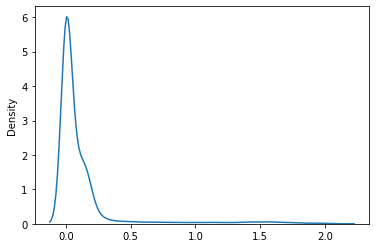

In [125]:
import seaborn as sns
sns.kdeplot(_[:,0])